# ARMAモデルによるfxデータの推定
!対数差分を取らない

# fxデータ読み込み

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../module')
from utils import log_diff, log_diff_inv, load_fx_data, nrmse
from kalman_filters import LinearKalmanFilter as LKF
from kalman_filters import ExtendedKalmanFilter as EnKF


np.random.seed(0)

In [3]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']

df_dict_train = load_fx_data(instrument_list, data_kind='train')
df_dict_test = load_fx_data(instrument_list, data_kind='test')

df_dict_train['EUR_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,144.926,145.163,142.859,143.366,143014,144.776,145.108,142.838,143.228
2014-01-02 22:00:00+00:00,143.387,143.387,141.975,142.527,113868,143.237,143.306,141.951,142.412
2014-01-05 22:00:00+00:00,142.515,142.793,141.512,142.080,125100,142.464,142.775,141.491,142.007
2014-01-06 22:00:00+00:00,142.080,142.600,141.951,142.449,115303,142.006,142.584,141.930,142.377
2014-01-07 22:00:00+00:00,142.449,143.184,142.130,142.405,128572,142.380,143.161,142.109,142.316
...,...,...,...,...,...,...,...,...,...
2018-12-03 22:00:00+00:00,129.037,129.065,127.632,127.951,26900,128.927,129.019,127.613,127.901
2018-12-04 22:00:00+00:00,127.989,128.502,127.801,128.439,16113,127.939,128.483,127.782,128.389
2018-12-05 22:00:00+00:00,128.433,128.468,127.683,128.214,37536,128.383,128.418,127.663,128.164


In [4]:
train = df_dict_train['USD_JPY']['Close_ask'].values[1:]
test = df_dict_test['USD_JPY']['Close_ask'].values[1:]
print(train.shape, test.shape)

# 正規化
train = (train - train.mean())/train.std()
test  = (test - test.mean())/test.std()

std_train = train.std()
train_diff_std = np.diff(train).std()
print(f'diff std: {train_diff_std}')

(1297,) (274,)
diff std: 0.09579385045862122


In [5]:
# 参考までに現在の値を明日の予測値とする場合の誤差
print(f'rough estimate nrmse: {nrmse(train[1:],train[:-1], std_train)}')

rough estimate nrmse: 0.09579552857347758


# ARMAモデルの作成

In [6]:
def generate_state_data(F, G, q, x_0, size):
    """
    モデルノイズは1次元を仮定
    """
    data = np.zeros((size, len(x_0)))
    x = x_0
    data[0] = x
    for i in range(1, size):
        x = F@x + G@np.random.normal(loc=0, scale=q, size=(1,))
        data[i] = x
    return data

def generate_obs_data(H, r, series, noise=True):
    """
    観測ノイズは1次元を仮定
    """
    obs = (H@series.T).T
    if noise:
        obs += np.random.normal(loc=0, scale=r, size=(len(series),1))
    return obs

In [7]:
# ARモデル
p = 10
a = -1*np.ones(p).reshape(p, 1)

# MAモデル
q = 0
b = np.zeros(q)
# b = np.array([0.5, 0.5, 0.5])

N = max([p,q+1])
print(f'p = {p}, q = {q}, N = {N}')

# a, bを0拡張
if N > p:
    a_N = np.vstack([a, np.zeros(N-p)])
else:
    a_N = a

if N > q+1:
    b_N = np.hstack([b, np.zeros(N-q-1)])
else:
    b_N = b

# 状態遷移行列 (N, N)
F = np.block([a_N, np.vstack([np.eye(N-1), np.zeros((1, N-1))])])
print(f'F = \n{F}')

# ノイズ重み (N, 1), b_0=1を含む． 
G = np.array([1, *b_N]).reshape(N, 1)
print(f'G = \n{G}')

# 観測モデル (1, N)
H = np.block([1, np.zeros((1, N-1))])
print(f'H_ma = \n{H}')

# ノイズ
sigma_train = train.std()

# モデルノイズstd
sigma_m = train_diff_std
Q = np.array([sigma_m])
print(f'model noise: {sigma_m}')
# 観測ノイズstd
sigma_o = train_diff_std/10
r = sigma_o
R = np.array([r])
print(f'obs noise: {sigma_o}')

p = 10, q = 0, N = 10
F = 
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
G = 
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
H_ma = 
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
model noise: 0.09579385045862122
obs noise: 0.009579385045862122


## LKF


In [8]:
y = train
x_0 = np.hstack([np.random.choice(train, 1), np.zeros(N-1)])
P_0 = 10*np.eye(N)

In [9]:
# 推定
lkf = LKF(F, H, G, Q, R, y, x_0, P_0, alpha=1., storing_forecast=True)
lkf.forward_estimation()
estimate_data = (H@(np.array(lkf.x)).T).T
step_f_data = (H@(np.array(lkf.x_f_history)).T).T

### plot

x_a nrmse: 0.25078509485760986


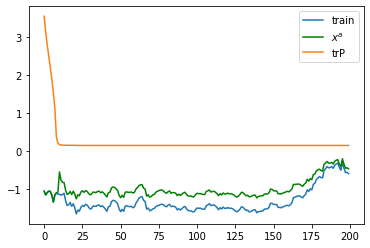

In [10]:
# trainデータに対するフィッティング
end = 200
plt.plot(train[:end], '-', label='train')
plt.plot(estimate_data[:end], 'g-', label='$x^a$')
plt.plot(lkf.trP[:end], label='trP')
plt.legend()

# 評価
lkf_xa_nrmse = nrmse(train, estimate_data.reshape(-1,), std_train)
print(f'x_a nrmse: {lkf_xa_nrmse}')

x_f nrmse: 3.670457724209181


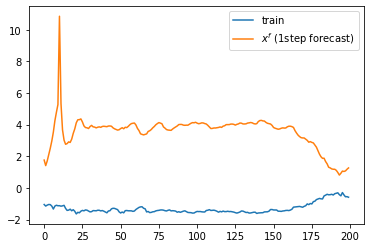

In [11]:
# 1step後の予測
plt.plot(train[:end], '-', label='train')
plt.plot(step_f_data[:end], '-',label='$x^f$ (1step forecast)')
plt.legend()

# 評価
lkf_xf_nrmse = nrmse(train, step_f_data.reshape(-1,), std_train)
print(f'x_f nrmse: {lkf_xf_nrmse}')

### 長期予測

nrmse: 1.0839382706261111


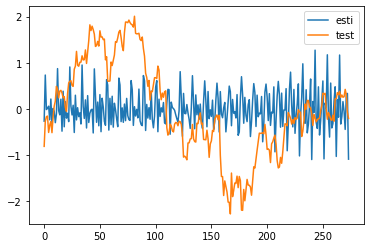

In [12]:
# lkfによるtest予測失敗 2021/01/09
end = 100
esti = generate_state_data(F, G, Q[0], lkf.x[-1], len(test))
obs_esti_data = generate_obs_data(H, R[0], esti, noise=False)
plt.plot(obs_esti_data, label='esti')
plt.plot(test, label='test')
plt.legend()

# 評価
lkf_test_nrmse = nrmse(test, obs_esti_data.reshape(-1,), std_train)
print(f'nrmse: {lkf_test_nrmse}')

## EnKFで同時にパラメータ推定

In [13]:
# パラメータ推定モデル
# given N
# 自己回帰パラメータaを推定する．

def F_a(a):
    """
    args:
        a: np.ndarray(N,1)
    """
    return np.block([a.reshape(N, 1), np.vstack([np.eye(N-1), np.zeros((1, N-1))])])

# def G_b(b):
#     """
#     args:
#         b: np.ndarray(N-1,)
#     """
#     return np.array([1, *b]).reshape(N, 1)

# 非線形モデル
def M(X, dt):
    """
    args:
        X: np.ndarray(2N,)
            X = (x, a)
        dt: float
    """
    return np.hstack([F_a(X[N:])@X[:N], X[N:]])

# G,Hのサイズを拡張
H_params = np.block([1, np.zeros((1, 2*N-1))])
G_params = np.vstack([G, np.zeros((N,1))])

In [14]:
# 推定
y = train
x_0 = np.random.choice(train, N)
a_0 = a_N
X_0 = np.hstack([x_0, a_N.reshape(-1,)])
P_0 = 10*np.eye(2*N)
enkf = EnKF(M, H_params, G_params, Q, R, y, X_0, P_0, alpha=1., storing_forecast=True)
enkf.forward_estimation()
enkf_estimate_data = (H_params@(np.array(enkf.x)).T).T
enkf_step_f_data = (H_params@(np.array(enkf.x_f_history)).T).T

### plot

x_a nrmse: 0.007653729133824504
x_f nrmse: 0.2662094928672011


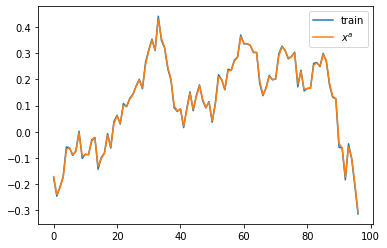

In [15]:
# 1stepごとに予測(x_f)
start = 1200
plt.plot(train[start:], label='train')
plt.plot(enkf_estimate_data[start:], label='$x^a$')
# plt.plot(enkf_step_f_data[start:], label='$x^f$')
plt.legend()

# 評価
enkf_xa_nrmse = nrmse(train, enkf_estimate_data.reshape(-1,), std_train)
enkf_xf_nrmse = nrmse(train, enkf_step_f_data.reshape(-1,), std_train)
print(f'x_a nrmse: {enkf_xa_nrmse}')
print(f'x_f nrmse: {enkf_xf_nrmse}')

nrmse: 1.5087572393616144


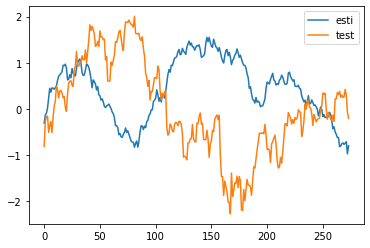

In [16]:
# 推定後パラメータによるARモデルでtestを予測
end = 2000
a_esti = enkf.x[-1][N:]
np.random.seed(0)
enkf_esti = generate_state_data(F_a(a_esti), G, Q[0], enkf.x[-1][:N], len(test))
enkf_obs_esti_data = generate_obs_data(H, R[0], enkf_esti, noise=False)
plt.plot(enkf_obs_esti_data[:end], label='esti')
plt.plot(test[:end], label='test')
plt.legend()

# 評価
enkf_test_rmse = nrmse(test, enkf_obs_esti_data.reshape(-1,), std_train)
print(f'nrmse: {enkf_test_rmse}')

array([1.10206461, 0.08954866, 0.03748509, 0.06440355, 0.12763261,
       0.15288987, 0.066699  , 0.04623843, 0.07210547, 0.0287749 ])

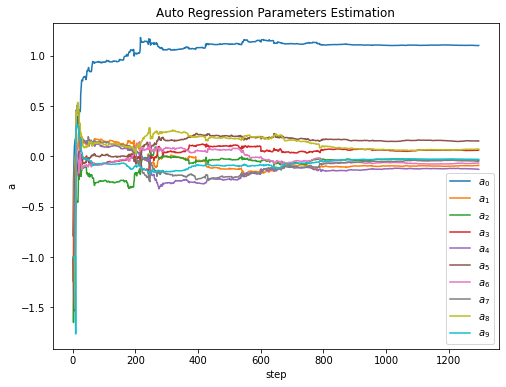

In [27]:
# 自己回帰パラメータの推定結果
fig = plt.figure(figsize=(8,6))
for n in range(N):
    plt.plot(np.array(enkf.x)[:, N+n], label=f'$a_{n}$')
plt.xlabel('step')
plt.ylabel('a')
plt.title('Auto Regression Parameters Estimation')
plt.legend()
fig.savefig(f'../data/img/ar_params_estimate_{N}.png')
np.abs(np.array(enkf.x)[-1, N:])


## 2021/01/17観察
- 自己回帰パラメータは$a_1$が1近くでそれ以外はほとんど0になっている